In [1]:
import leapfrog as lf
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader, TensorDataset

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
def activation(x):
    return torch.nn.LeakyReLU()(torch.tensor(x)).numpy()
def generate_data():
    rng = np.random.RandomState(0)
    X  = rng.multivariate_normal(np.zeros(p), np.identity(p), n)
    t1 = activation( 1.1*X[:,5] - 0.8*X[:,6])
    t2 = activation( 1.4*X[:,7] - 1.3*X[:,8])
    t3 = sigmoid   ( 1.2*t1     + 1.3*t2     - 1.2)
    y  = t3 > 0.5
    return X, y

In [3]:
# Number of samples
n = 10000
# Number of features
p = 10
# Generate features X and labels y
X, y = generate_data()

In [4]:
class TwoLayerModel(torch.nn.Module):
    def __init__(self, p, q, k, weight_decay=None):
        super(TwoLayerModel, self).__init__()
        # First layer is subject to leapfrog regularization
        self.linear1 = lf.Linear(p, k, q, weight_decay=weight_decay)
        # Second layer is dense
        self.linear2 = torch.nn.Linear(k, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x

---
## Train standard leapfrog path
---

In [5]:
# Specify a list of the number of features we want to estimate
q = [0,1,2,3,4,5,10]

# Define a simple logistic regression model
model = TwoLayerModel(X.shape[1], q, 2)

# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.005)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 10000
# Define the training set and data loader for training, with
# a batch size equal to the full training set (i.e. do not use
# stochastic gradient descent, because the data set and model
# are fairly small)
trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_      = []
# Record the loss
loss_   = []
# Record the coefficients (weights) of the model
coefs1_ = []
coefs2_ = []
while True:
  # Do a maximum of max_epochs iterations over the training set
  for _epoch in range(0, max_epochs):
    # Loop over the training set
    for i, data in enumerate(trainloader, 0):
      # Get X (inputs) and y (targets)
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      # Backpropagate gradient
      loss.backward()
      # Perform one gradient descent step
      optimizer.step()
      # Record loss
      loss_.append(loss.item())

      #print(f'Loss: {loss.item()}')

    # Check if optimizer converged (only possible of no
    # stochastic gradient descent is used), or if the
    # maximum number of epochs is reached
    if optimizer.converged(loss.item()) or _epoch == max_epochs-1:
      # Do not record solution if q is None
      if optimizer.get_q()[0] is None:
        break
      # Record lambda (weight decay)
      weight_decay = optimizer.get_weight_decay()
      # Each layer and output node has its own weight decay parameter. We
      # have only one layer and output node.
      l_.append(weight_decay[0][0].item())
      # Record coefficients (weights) from the linear layer
      coefs1_.append(list(model.parameters())[0][0].detach().numpy().copy())
      coefs2_.append(list(model.parameters())[0][1].detach().numpy().copy())
      break

  print(f'Training process has finished for target q={optimizer.get_q()[0]}.')
  # Select the next q (number of features) for optimization
  if optimizer.next_target():
    # There are no more targets, exit loop
    break

Training process has finished for target q=0.
Training process has finished for target q=1.
Training process has finished for target q=2.
Training process has finished for target q=3.
Training process has finished for target q=4.
Training process has finished for target q=5.
Training process has finished for target q=10.


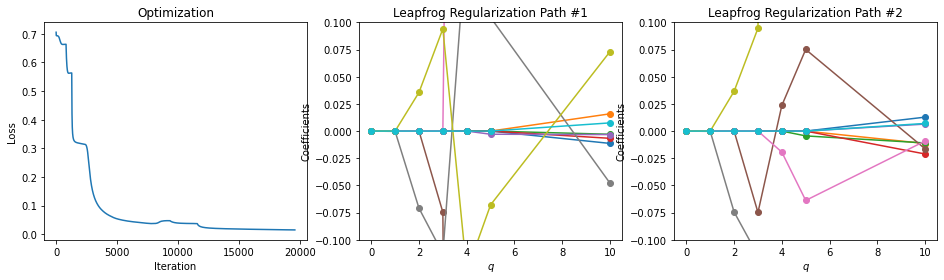

In [6]:
plt.rcParams['figure.figsize'] = [16, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(np.array(q)[np.array(q) != None], np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$q$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax2.set_ylim(-0.1,0.1)
ax3.plot(np.array(q)[np.array(q) != None], np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$q$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
ax3.set_ylim(-0.1,0.1)
plt.show()

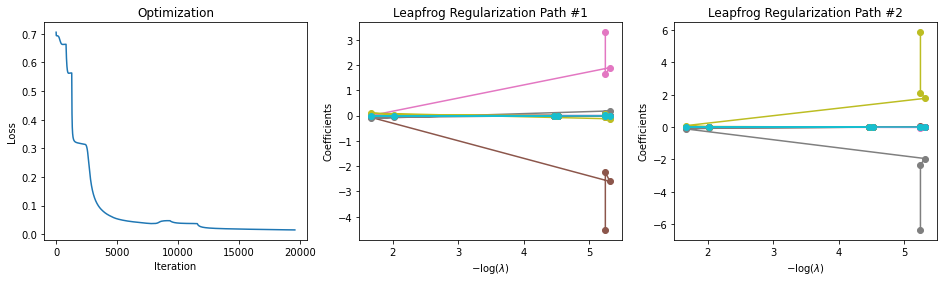

In [7]:
plt.rcParams['figure.figsize'] = [16, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(-np.log(l_), np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$-\log(\lambda)$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(-np.log(l_), np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$-\log(\lambda)$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.show()

---
## Train reverse order
---

In [8]:
# Specify a list of the number of features we want to estimate
q = [10,5,4,3,2,1,0]

# Define a simple logistic regression model
model = TwoLayerModel(X.shape[1], q, 2)

# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.005)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 10000
# Define the training set and data loader for training, with
# a batch size equal to the full training set (i.e. do not use
# stochastic gradient descent, because the data set and model
# are fairly small)
trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_      = []
# Record the loss
loss_   = []
# Record the coefficients of the logistic regression
coefs1_ = []
coefs2_ = []
while True:
  # Do a maximum of max_epochs iterations over the training set
  for _epoch in range(0, max_epochs):
    # Loop over the training set
    for i, data in enumerate(trainloader, 0):
      # Get X (inputs) and y (targets)
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      # Backpropagate gradient
      loss.backward()
      # Perform one gradient descent step
      optimizer.step()
      # Record loss
      loss_.append(loss.item())

      #print(f'Loss: {loss.item()}')

    # Check if optimizer converged (only possible of no
    # stochastic gradient descent is used), or if the
    # maximum number of epochs is reached
    if optimizer.converged(loss.item()) or _epoch == max_epochs-1:
      # Record lambda (weight decay)
      weight_decay = optimizer.get_weight_decay()
      # Each layer and output node has its own weight decay parameter. We
      # have only one layer and output node.
      l_.append(weight_decay[0][0].item())
      # Record coefficients (weights) from the linear layer
      coefs1_.append(list(model.parameters())[0][0].detach().numpy().copy())
      coefs2_.append(list(model.parameters())[0][1].detach().numpy().copy())
      break

  print(f'Training process has finished for target q={optimizer.get_q()[0]}.')
  # Select the next q (number of features) for optimization
  if optimizer.next_target():
    # There are no more targets, exit loop
    break

Training process has finished for target q=10.
Training process has finished for target q=5.
Training process has finished for target q=4.
Training process has finished for target q=3.
Training process has finished for target q=2.
Training process has finished for target q=1.
Training process has finished for target q=0.


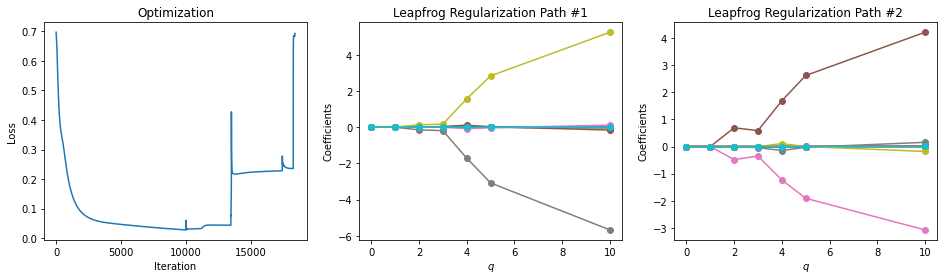

In [9]:
plt.rcParams['figure.figsize'] = [16, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(q, np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$q$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(q, np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$q$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.show()

/tmp/ipykernel_18579/4258633370.py:8: RuntimeWarning: divide by zero encountered in log
  ax2.plot(-np.log(l_), np.array(coefs1_), marker="o")
/tmp/ipykernel_18579/4258633370.py:13: RuntimeWarning: divide by zero encountered in log
  ax3.plot(-np.log(l_), np.array(coefs2_), marker="o")


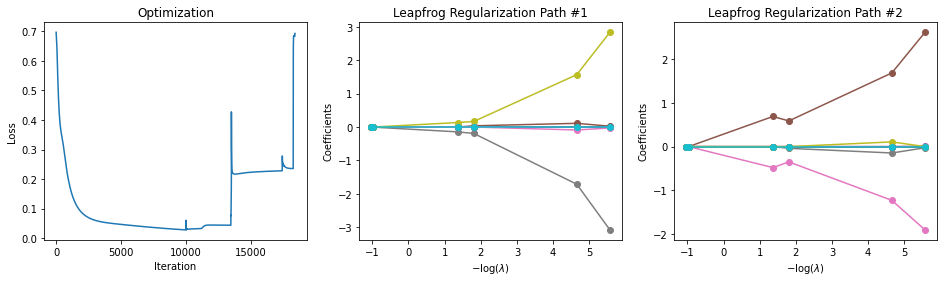

In [10]:
plt.rcParams['figure.figsize'] = [16, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(-np.log(l_), np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$-\log(\lambda)$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(-np.log(l_), np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$-\log(\lambda)$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.show()

---
## Train with unconstrained relaxations
---

In [5]:
# Specify a list of the number of features we want to estimate
q = [0,None,1,None,2,3,4,5,10]

# Define a simple logistic regression model
model = TwoLayerModel(X.shape[1], q, 2)

# Logistic regression models are trained using the binary cross-entropy
loss_function = torch.nn.BCELoss()
# We use a standard optimizer such as Adam...
optimizer     = torch.optim.Adam(model.parameters(), lr=0.005)
# and augment it with a Leapfrog optimizer that performs the
# regularization steps
optimizer     = lf.Optimizer(optimizer, tolerance=1e-8)
# A maximum of max_epochs is used for training
max_epochs    = 10000
# Define the training set and data loader for training, with
# a batch size equal to the full training set (i.e. do not use
# stochastic gradient descent, because the data set and model
# are fairly small)
trainloader   = DataLoader(
  TensorDataset(torch.Tensor(X), torch.Tensor(y)),
  batch_size=int(X.shape[0]),
  shuffle=False,
  num_workers=1)

# Record the regularization strength lambda
l_      = []
# Record the loss
loss_   = []
# Record the coefficients of the logistic regression
coefs1_ = []
coefs2_ = []
while True:
  # Do a maximum of max_epochs iterations over the training set
  for _epoch in range(0, max_epochs):
    # Loop over the training set
    for i, data in enumerate(trainloader, 0):
      # Get X (inputs) and y (targets)
      inputs, targets = data
      # Reset gradient
      optimizer.zero_grad()
      # Evaluate model
      outputs = torch.flatten(model(inputs))
      # Compute loss
      loss = loss_function(outputs, targets)
      # Backpropagate gradient
      loss.backward()
      # Perform one gradient descent step
      optimizer.step()
      # Record loss
      loss_.append(loss.item())

      #print(f'Loss: {loss.item()}')

    # Check if optimizer converged (only possible of no
    # stochastic gradient descent is used), or if the
    # maximum number of epochs is reached
    if optimizer.converged(loss.item()) or _epoch == max_epochs-1:
      # Do not record solution if q is None
      if optimizer.get_q()[0] is None:
        break
      # Record lambda (weight decay)
      weight_decay = optimizer.get_weight_decay()
      # Each layer and output node has its own weight decay parameter. We
      # have only one layer and output node.
      l_.append(weight_decay[0][0].item())
      # Record coefficients (weights) from the linear layer
      coefs1_.append(list(model.parameters())[0][0].detach().numpy().copy())
      coefs2_.append(list(model.parameters())[0][1].detach().numpy().copy())
      break

  print(f'Training process has finished for target q={optimizer.get_q()[0]}.')
  # Select the next q (number of features) for optimization
  if optimizer.next_target():
    # There are no more targets, exit loop
    break


Training process has finished for target q=0.
Training process has finished for target q=None.
Training process has finished for target q=1.
Training process has finished for target q=None.
Training process has finished for target q=2.
Training process has finished for target q=3.
Training process has finished for target q=4.
Training process has finished for target q=5.
Training process has finished for target q=10.


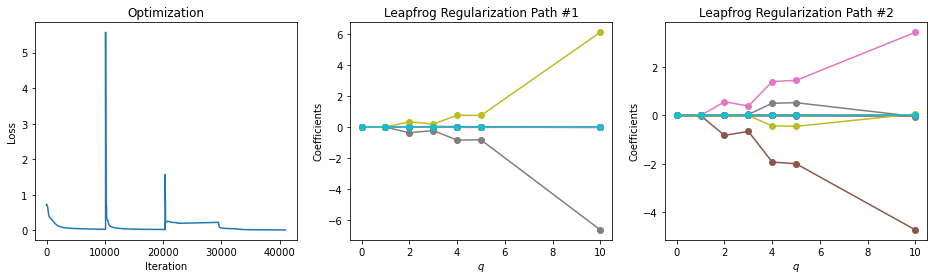

In [6]:
plt.rcParams['figure.figsize'] = [16, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(np.array(q)[np.array(q) != None], np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$q$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(np.array(q)[np.array(q) != None], np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$q$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.show()

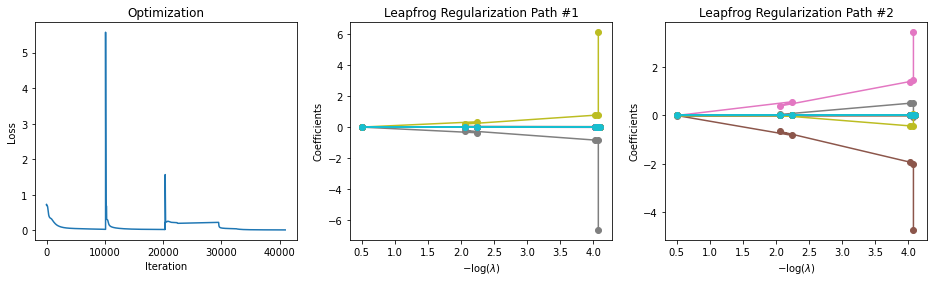

In [7]:
plt.rcParams['figure.figsize'] = [16, 4]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(loss_), marker="")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")
ax1.set_title("Optimization")
ax1.axis("tight")
ax2.plot(-np.log(l_), np.array(coefs1_), marker="o")
ax2.set_xlabel(r"$-\log(\lambda)$")
ax2.set_ylabel("Coefficients")
ax2.set_title("Leapfrog Regularization Path #1")
ax2.axis("tight")
ax3.plot(-np.log(l_), np.array(coefs2_), marker="o")
ax3.set_xlabel(r"$-\log(\lambda)$")
ax3.set_ylabel("Coefficients")
ax3.set_title("Leapfrog Regularization Path #2")
ax3.axis("tight")
plt.show()